In [22]:
import warnings
warnings.filterwarnings('ignore')
import stwcs
import glob
import sys
import os
import shutil
import time
import filecmp
import astroquery
import progressbar
import copy
import requests
import random
import astropy.wcs as wcs
import numpy as np
from contextlib import contextmanager
from astropy import units as u
from astropy.utils.data import clear_download_cache,download_file
from astropy.io import fits
from astropy.table import Table, Column, unique
from astropy.time import Time
from astroscrappy import detect_cosmics
from stwcs import updatewcs
from scipy.interpolate import interp1d

# Internal dependencies
from common import Constants
from common import Options
from common import Settings
from common import Util
from nbutils import get_filter, get_instrument, get_chip, get_filter, input_list
from nbutils import get_zpt, add_visit_info, organize_reduction_tables, pick_deepest_images

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

with suppress_stdout():
    from drizzlepac import tweakreg,astrodrizzle,catalogs,photeq
    from astroquery.mast import Observations
    from astropy.coordinates import SkyCoord

In [35]:
import glob,os
import jwst
from astropy.io import fits
print(f'JWST version: {jwst.__version__}')

root_dir = '.'
filter_name = 'F090W'
inputfiles_level3_filter = glob.glob('jwstred_temp_dolphot/raw/*cal_err.fits')[:1]

JWST version: 1.14.0


In [36]:
inputfiles_level3_filter

['jwstred_temp_dolphot/raw/jw01334001001_04101_00002_nrcb3_cal_err.fits']

In [26]:
#write out err file
hdu = fits.open(inputfiles_level3_filter[0])
err = hdu['ERR'].data
hdu['SCI'].data = err
hdu.writeto('jwstred_temp_dolphot/raw/jw01334001001_04101_00002_nrcb3_cal_err.fits', overwrite = True)

In [37]:
from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

In [38]:
input_images = inputfiles_level3_filter
table = input_list(input_images)
tables = organize_reduction_tables(table, byvisit=False)

In [39]:
table = table[(table['filter'] == 'f090w') | (table['filter'] == 'f150w')]
filter_name = 'f090w_f150w'

In [40]:
filter_name = table[0]['filter']

In [41]:
nircam_asn_file = f'jwstred_temp_dolphot/{filter_name}.json'
base_filenames = np.array([os.path.join('raw', os.path.basename(r['image'])) for r in table])
asn3 = asn_from_list.asn_from_list(base_filenames, 
    rule=DMS_Level3_Base, product_name=filter_name)

In [42]:
with open(nircam_asn_file, 'w') as outfile:
    name, serialized = asn3.dump(format='json')
    outfile.write(serialized)

In [43]:
print(asn3)

jwnoprogram-a3001_none_00003_asn with 1 products
Rule=DMS_Level3_Base
No constraints
Products:
	f150w with 1 members


In [44]:
from jwst.pipeline import calwebb_image3
image3 = calwebb_image3.Image3Pipeline()

outdir_level3 = os.path.join('jwstred_temp_dolphot/', 'out_filter')
if not os.path.exists(outdir_level3):
    os.makedirs(outdir_level3)

image3.output_dir = outdir_level3
image3.save_results = True
image3.tweakreg.skip = True
image3.skymatch.skip = True
image3.skymatch.match_down = False
image3.source_catalog.skip = False
image3.resample.pixfrac = 0.8
# image3.resample.crpix = [1500, 1500]

image3.run(nircam_asn_file)

2024-11-05 18:50:53,729 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2024-11-05 18:50:53,731 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2024-11-05 18:50:53,735 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2024-11-05 18:50:53,737 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2024-11-05 18:50:53,739 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2024-11-05 18:50:53,741 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2024-11-05 18:50:53,742 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2024-11-05 18:50:53,851 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('jwstred_temp_dolphot/f150w.json',).
2024-11-05 18:50:53,858 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: 

In [48]:
#detection image
det_sci_hdu = fits.open('jwstred_temp_dolphot/out_filter/f150w_i2d_sci.fits')
det_err_hdu = fits.open('jwstred_temp_dolphot/out_filter/f150w_i2d_err.fits')
snr_dat = det_sci_hdu['SCI'].data/det_err_hdu['SCI'].data
det_sci_hdu['SCI'].data = snr_dat
det_sci_hdu.writeto('jwstred_temp_dolphot/out_filter/f150w_i2d_snr.fits')

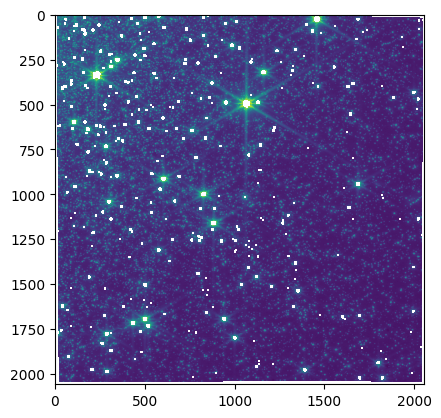

In [47]:
import matplotlib.pyplot as plt
plt.imshow(snr_dat)
plt.show()